In [27]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import sklearn

In [2]:
#df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/train.csv')
df = pd.read_csv('train.csv')

In [3]:
# make one feature of Country_Region and Province_State
df = df.fillna("all")
df['Region'] = df['Country_Region'] + ',' + df['Province_State']

# Add feature 'date_index' that is date converted to cumulative int
df['date_index'] = df.groupby('Region').cumcount()

In [4]:
# add feature date since 1st case
df['date_since_1st_case'] = df.loc[df['ConfirmedCases'] > 0].groupby('Region').cumcount()
df['date_since_1st_case'] = df['date_since_1st_case'].fillna(0)

In [5]:
df.loc[df['Region'] == 'Italy,all']['ConfirmedCases'].plot()

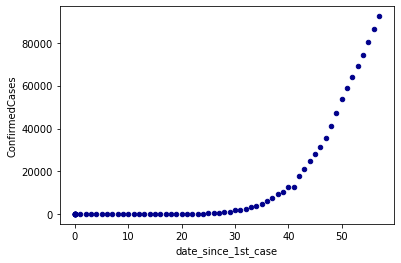

In [6]:
df.loc[df['Region'] == 'Italy,all'].plot.scatter(x='date_since_1st_case', y='ConfirmedCases', c='DarkBlue')

In [7]:
# 'Region' to categorical ints
df['Region'] = df['Region'].astype('category')
df['Region_id'] = df['Region'].cat.codes

In [9]:
#country_info = pd.read_csv('/kaggle/input/countryinfo/covid19countryinfo.csv', thousands=',')
country_info = pd.read_csv('covid19countryinfo.csv', thousands=',')
# select ones with region == NaN
country_info = country_info.loc[country_info['region'].isnull()]

# get population data
country_info = country_info.rename(columns = {'country' : 'Country_Region'})
df = df.join(country_info[['Country_Region', 'pop']].set_index('Country_Region'), on='Country_Region')

# add missing data
df.loc[df['Country_Region'] == 'Papua New Guinea', 'pop'] = 8904152
df.loc[df['Country_Region'] == 'Angola', 'pop'] = 32591460

In [10]:
df.tail()

Id Province_State Country_Region        Date  ConfirmedCases  \
19693  29363            all       Zimbabwe  2020-03-24             3.0   
19694  29364            all       Zimbabwe  2020-03-25             3.0   
19695  29365            all       Zimbabwe  2020-03-26             3.0   
19696  29366            all       Zimbabwe  2020-03-27             5.0   
19697  29367            all       Zimbabwe  2020-03-28             7.0   

       Fatalities        Region  date_index  date_since_1st_case  Region_id  \
19693         1.0  Zimbabwe,all          62                  4.0        293   
19694         1.0  Zimbabwe,all          63                  5.0        293   
19695         1.0  Zimbabwe,all          64                  6.0        293   
19696         1.0  Zimbabwe,all          65                  7.0        293   
19697         1.0  Zimbabwe,all          66                  8.0        293   

              pop  
19693  14862924.0  
19694  14862924.0  
19695  14862924.0  
19696  14862924.0  
19697  14862924.0

In [24]:
# train-test splitting
split_day = 60
X_train = df.loc[df['date_index'] < split_day][['Region_id','date_index', 'date_since_1st_case', 'pop']]
X_test = df.loc[df['date_index'] >= split_day][['Region_id','date_index', 'date_since_1st_case', 'pop']]
y_train = df.loc[df['date_index'] < split_day][['ConfirmedCases']].values.flatten()
y_test = df.loc[df['date_index'] >= split_day][['ConfirmedCases']].values.flatten()

In [28]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
#sklearn.metrics.mean_squared_error(y_test, y_pred)
np.sqrt(sklearn.metrics.mean_squared_log_error(y_test, y_pred))

1.4820637414706272

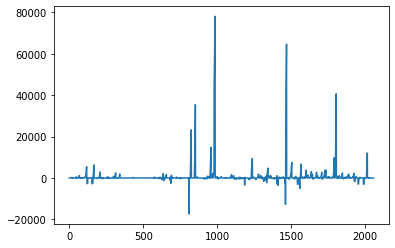

In [30]:
# Plot the residuals
plt.plot((y_test - y_pred))

In [31]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
country_name = 'Sweden'
country_data = df.loc[df['Country_Region'] == country_name]['ConfirmedCases'].values

In [33]:
# Let's split the data to test and train sequences
test_size = 10
train_data = country_data[:-test_size]
test_data = country_data[-test_size:]

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_norm = scaler.fit_transform(train_data.reshape(-1, 1))

# Convert the normalized train data to PyTorch tensor
train_data_norm = torch.FloatTensor(train_data_norm).view(-1)

In [34]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [35]:
# Adjust the train_window according to the data
train_window = 15
train_inout_seq = create_inout_sequences(train_data_norm, train_window)
lr_rate = 0.001
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

# training loop
n_epochs = 150
for i in range(n_epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

    if i % 25 == 1:
        print("Epoch:", i, "Loss:", round(loss.item(), 2))

print("Epoch:", i, "Loss:", round(loss.item(), 2))
print("Training finished!")

Epoch: 1 Loss: 1.17
Epoch: 26 Loss: 0.01
Epoch: 51 Loss: 0.0
Epoch: 76 Loss: 0.02
Epoch: 101 Loss: 0.0
Epoch: 126 Loss: 0.02
Epoch: 149 Loss: 0.0
Training finished!


In [37]:
fut_pred = 10
test_inputs = train_data_norm[-train_window:].tolist()

model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [38]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1)).flatten()
print(actual_predictions.astype(int).flatten())

[1349 1412 1466 1511 1546 1573 1593 1607 1617 1624]


In [40]:
print("Root mean squared logarithmic error:", np.sqrt(sklearn.metrics.mean_squared_log_error(test_data, actual_predictions)))

Root mean squared logarithmic error: 0.42999628388397776


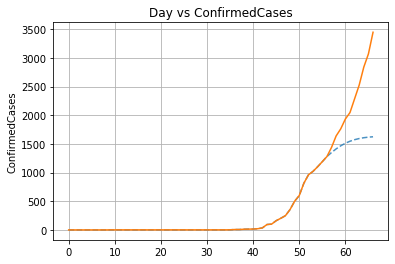

In [42]:
validation_data = np.concatenate((train_data, actual_predictions), axis=0)
plt.title('Day vs ConfirmedCases')
plt.ylabel('ConfirmedCases')
plt.grid(True)

plt.plot(validation_data,'--', alpha = 0.8)
plt.plot(country_data)
plt.show()